In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [129]:
DF = pd.read_excel('PQM dataset.xlsx', sheet_name='Frequency_1 hrs')
print("DataFrame shape:", DF.shape)
print("NaN vlues:", DF.isna().sum().sum())

DataFrame shape: (6005, 7)
NaN vlues: 2529


In [130]:
cleanDF = DF.dropna()   #fillna(DF.mean())

In [131]:
# calculating z-scores for outlier detection
def calc_zscore(column):
    mean = np.mean(column)
    std_dev = np.std(column)

    if std_dev == 0:
        return np.zeros_like(column)
    
    z_scores = (column - mean) / std_dev
    return z_scores

In [132]:
columns = [col for col in cleanDF.columns if col not in ['TimeID']]

z_scores = cleanDF[columns].apply(calc_zscore)

print(z_scores.head())

      Col_1     Col_2     Col_3     Col_4     Col_5     Col_6
0  0.024241  2.714786 -3.267434  2.745725 -3.181424  0.024784
1  0.024241  2.717482 -3.269669  2.748585 -3.183691  0.024784
2  0.024241  2.717369 -3.268072  2.748466 -3.182071  0.024784
3  0.024599  2.717145 -3.266795  2.748227 -3.180776  0.025142
4  0.024241  2.715572 -3.268551  2.746559 -3.182557  0.024784


In [133]:
#finding outliers and cleaning data
outlier_mask = (np.abs(z_scores) > 4).any(axis=1)
print(f"Found {outlier_mask.sum()} outliers in the dataset")

#cleanDF = cleanDF[~outlier_mask]
#print("Cleaned DataFrame shape:", cleanDF.shape)

Found 30 outliers in the dataset


In [134]:
# window size = 4 because we have 6 columns
input_size = 4
power_columns = [col for col in cleanDF.columns if col != 'TimeID']

x_list = []
y_list = []

In [135]:
for i in range(len(power_columns) - input_size):
    input_window = power_columns[i:i + input_size]
    target_column = power_columns[i + input_size]

    input_values = cleanDF[input_window].values
    
    # calculating rolling statistics
    rolling_mean = np.mean(input_values, axis=1).reshape(-1, 1)
    rolling_std = np.std(input_values, axis=1).reshape(-1, 1)
    rolling_min = np.min(input_values, axis=1).reshape(-1, 1)
    rolling_max = np.max(input_values, axis=1).reshape(-1, 1)

    combined_features = np.hstack([input_values, rolling_mean, rolling_std, rolling_min, rolling_max])
    
    x_list.append(combined_features)
    y_list.append(cleanDF[target_column].values)

In [136]:
x = np.vstack(x_list)
y = np.hstack(y_list)

print("Input shape:", x.shape)
print("Target shape:", y.shape)

Input shape: (10324, 8)
Target shape: (10324,)


In [137]:
# test train split
split_index = int(0.8 * len(x))

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)
print("Number of NaN vaues in x_train:", np.isnan(x_train).sum())
print("Number of NaN values in y_train:", np.isnan(y_train).sum())

Training set shape: (8259, 8) (8259,)
Test set shape: (2065, 8) (2065,)
Number of NaN vaues in x_train: 0
Number of NaN values in y_train: 0


In [138]:
model = LinearRegression()
#model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [139]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 0.0293
Mean Squared Error (MSE): 0.0014
R-squared (R2): 0.6198


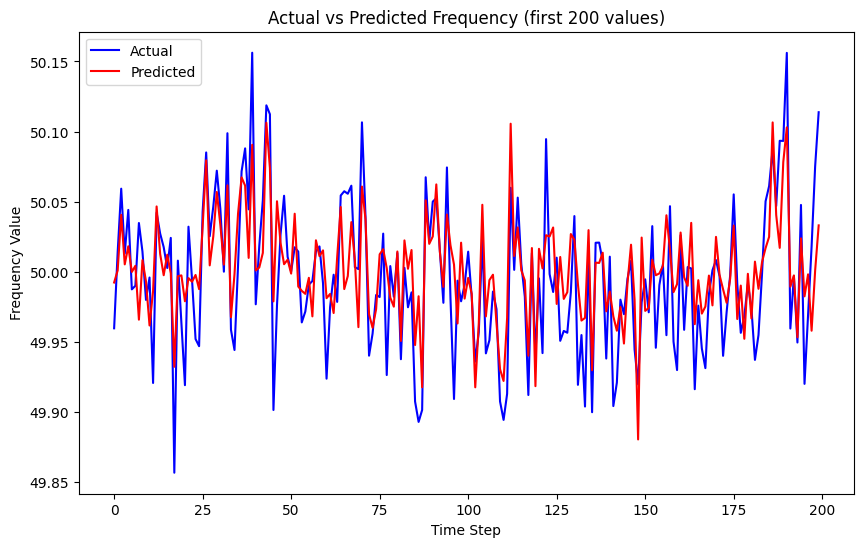

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Frequency (first 200 values)')
plt.xlabel('Time Step')
plt.ylabel('Frequency Value')
plt.legend()
plt.show()

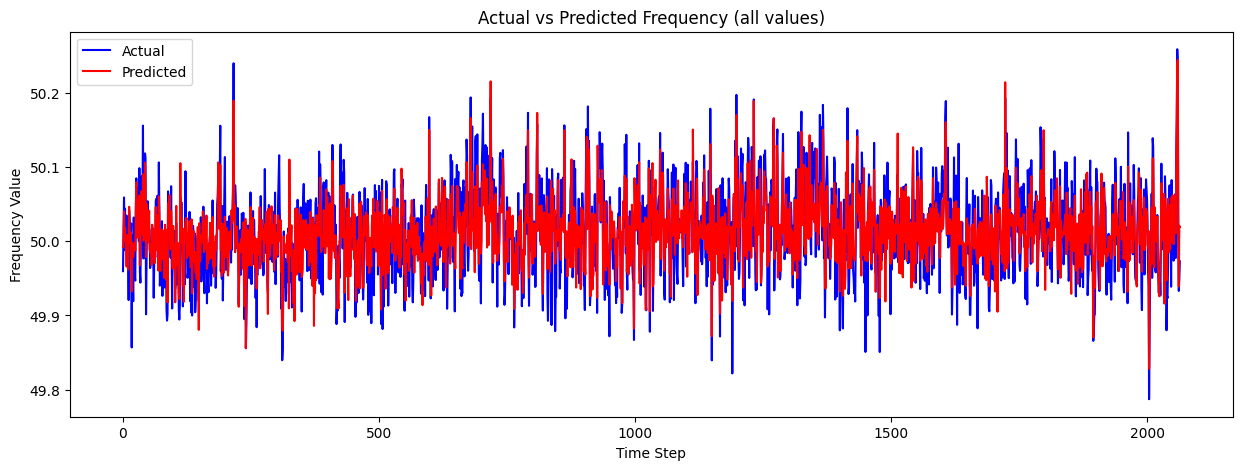

In [141]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Frequency (all values)')
plt.xlabel('Time Step')
plt.ylabel('Frequency Value')
plt.legend()
plt.show()